# Preparación de entorno

## Imports

In [1]:
from csv import reader

import numpy as np
import pandas as pd

from sklearn.cluster import KMeans

import math
import random
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import time
import datetime as dt

### Funciones y rutinas auxiliares

In [2]:
def load_csv(filename):
    file = open(filename, "r")
    lines = reader(file)
    dataset = list(lines)
    return dataset

# Exploración previa de los datos

### Carga de la BD

In [3]:
filename = 'data_practica.csv'
data = pd.read_csv(filename)

## Sobre los datos

In [4]:
data.head()

,Fecha,Cliente,Boleta,Producto,Cantidad,Venta,Costo
0,2017-01-02,1,1,1,1,1390,1294
1,2017-01-02,1,1,2,1,900,802
2,2017-01-02,1,1,3,1,890,813
3,2017-01-02,1,1,4,1,2490,2432
4,2017-01-02,1,1,5,1,1890,1607


**Chequeo de falta de datos**

In [5]:
data.isnull().sum(axis = 0)

Fecha       0
Cliente     0
Boleta      0
Producto    0
Cantidad    0
Venta       0
Costo       0
dtype: int64

** Generalidades **

In [6]:
N_clinetes = data.Cliente.nunique()
t_i = data['Fecha'][1]
t_f = data['Fecha'][len(data)-1]
Total_ventas = data['Venta'].sum()

print('Cantidad total de clientes : ' + str(N_clinetes)) #len(x['Cliente'].value_counts())
print('Fecha de incio del registro : ' + str(t_i))
print('Fecha de termino del registro : ' + str(t_f))
print('Total en ventas : ' + str(Total_ventas))

Cantidad total de clientes : 36272
Fecha de incio del registro : 2017-01-02
Fecha de termino del registro : 2017-12-31
Total en ventas : 4592992536


# Procesamiento y clusterización

El procesamiento previo a la clusterización se realiza para extraer las siguientes caracterísitcas:

** Recency: ** valor asignado por tiempo transcurrido desde la última compra a la fecha final de referencia. En este análisis los clientes con Recency 0 son los que han comprado más recientemente.

** Frequency: ** corresponde al total de transaciones realizadas por el cliente en el intervalo considerado (año 2017).

** Monetary: ** es el margen (venta - costo) acumulado de todas las transacciones realizadas por el cliente en el intervalo considerado.

De ese modo, los mejores clientes son aquellos que 1) son responsables de la mayor parte del margen, 2) compraron con mayor frecuencia anual y 3) han comprado más recientemente.

### ** Procesamiento **

Es importante correr estas rutinas en el orden que se presentan

In [7]:
seleccion = data[["Cliente","Fecha","Venta","Costo"]] # Nos quedamos con las columnas relevantes

In [8]:
RFM_muestra = pd.DataFrame(data=None, index=None, columns=['Cliente','Recency','Frequency','Monetary'], dtype=None, copy=False)

cliente_lim = 100 # Muestra de clientes considerada: N_clientes para recorrer toda la base de datos

for i in range(1, cliente_lim + 1):
    Cliente = i
    
    # frecuencia
    Frequency = seleccion['Cliente'].where( seleccion['Cliente'] == i ).count()
    
    # margen
    Monetary = seleccion['Venta'].where( seleccion['Cliente'] == i ).sum() - seleccion['Costo'].where( seleccion['Cliente'] == i ).sum()
    
    # fecha de ultima compra
    k = seleccion.where( seleccion['Cliente'] == i ).last_valid_index() 
    Recency = seleccion.loc[k].Fecha
    
    # nueva fila
    new_row = [Cliente, Recency, Frequency, Monetary]    
    RFM_muestra.loc[i-1] = new_row

RFM_muestra.to_pickle("./RFM_previo.pkl")    

RFM = RFM_muestra

# Para asignar valor de Recency
lastDate = dt.datetime(2017,12,31)
RFM['Recency'] = pd.to_datetime(RFM['Recency'])

df_1 = RFM.groupby('Cliente').agg({'Recency': lambda x: (lastDate - x.max()).days})
RFM['Recency'] = df_1.Recency.values

# se almacenan los datos procesados para evitar procesar nuevamente en futuras visualizaciones
RFM.to_pickle("./RFM.pkl")
RFM.head()

,Cliente,Recency,Frequency,Monetary
0,1,357,9,1081.0
1,2,0,771,87455.0
2,3,51,28,2410.0
3,4,154,34,2941.0
4,5,3,293,28385.0


** Lista para segmentación **

Esta lista permite asignar puntuaciones RFM entre 1 y 5, luego de ordenar ascendentemente los clientes de acuerdo a cada característica.

In [9]:
# Generamos la lista "Segmentos", que contiene igual cantidad de 1s, 2s, 3s, 4s y 5s, en orden ascentente.

Segmentos = []

cota = len(RFM)

for i in range(0,int(cota)):
    
    if i <= int(cota/5):
        Segmentos.append(1)
        
    if int(cota/5) < i <= 2*int(cota/5):
        Segmentos.append(2)
        
    if 2*int(cota/5) < i <= 3*int(cota/5):
        Segmentos.append(3)
        
    if 3*int(cota/5) < i <= 4*int(cota/5):
        Segmentos.append(4)
        
    if i > 4*int(cota/5):
        Segmentos.append(5)

In [10]:
# Se asocian puntajes R F M en base a los valores Recency, Frequency y Montary, respectivamente. Se emplea la segmentación
# explicada previamente.

for i in ['Recency','Frequency','Monetary']:
    
    # Se ordenan los valores de acuerdo a la característica y reordenan los indices
    RFM = RFM.sort_values(i, ascending=True)
    RFM.index = range(0,len(RFM))
    
    # Se adhiere la segmentación
    dat = pd.DataFrame({i[0]: Segmentos}) # i[0] permite recuperar las mayúsculas de Recency,Frequency y Monetary
    RFM = RFM.join(dat)

# Se ordena por clientes y reordenan los indices
RFM = RFM.sort_values('Cliente', ascending=True)
RFM.index = range(0,len(RFM))

RFM.head()

,Cliente,Recency,Frequency,Monetary,R,F,M
0,1,357,9,1081.0,5,1,1
1,2,0,771,87455.0,1,5,5
2,3,51,28,2410.0,4,1,1
3,4,154,34,2941.0,5,2,1
4,5,3,293,28385.0,3,3,3


** Se almacena el resultado para evitar procesar nuevamente en futuras visualizaciones **

In [11]:
RFM.to_pickle("./RFM_final.pkl")

### ** Clusterización **

** Se cargan los datos almacenados **

In [12]:
RFM_final = pd.read_pickle("./RFM_final.pkl")
RFM_final.head()

,Cliente,Recency,Frequency,Monetary,R,F,M
0,1,357,9,1081.0,5,1,1
1,2,0,771,87455.0,1,5,5
2,3,51,28,2410.0,4,1,1
3,4,154,34,2941.0,5,2,1
4,5,3,293,28385.0,3,3,3


** Clusterización por K-Means **

In [13]:
# Se realiza la clusterización
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0)
clusters = kmeans.fit_predict(RFM_final[['R','F','M']])

# Se registran los resultados de la clusterización en una columna adicional
datCluster = pd.DataFrame({'Cluster': clusters})
RFM_final = RFM_final.join(datCluster)

In [14]:
RFM_final.head()

,Cliente,Recency,Frequency,Monetary,R,F,M,Cluster
0,1,357,9,1081.0,5,1,1,1
1,2,0,771,87455.0,1,5,5,2
2,3,51,28,2410.0,4,1,1,1
3,4,154,34,2941.0,5,2,1,1
4,5,3,293,28385.0,3,3,3,0


# Visualización

Text(0.5,0,'Monetary')

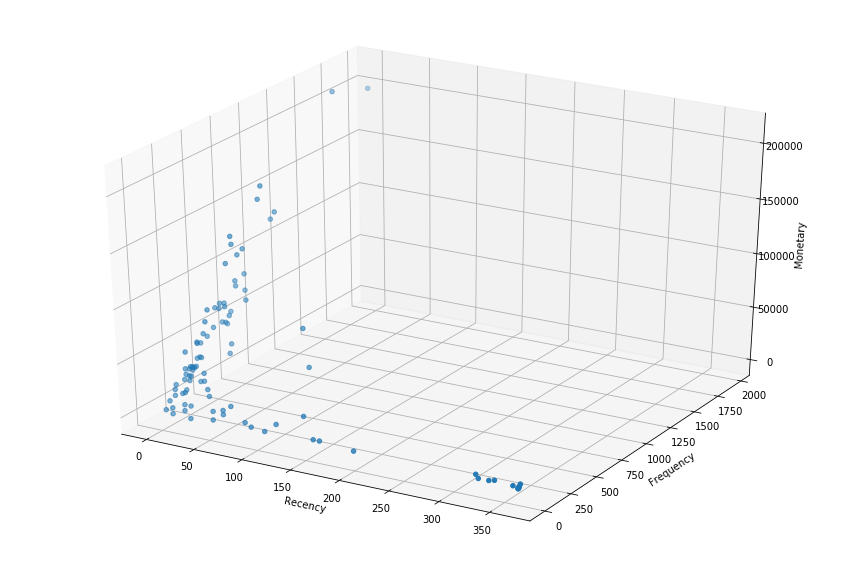

In [15]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(RFM_final.Recency, RFM_final.Frequency, RFM_final.Monetary)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

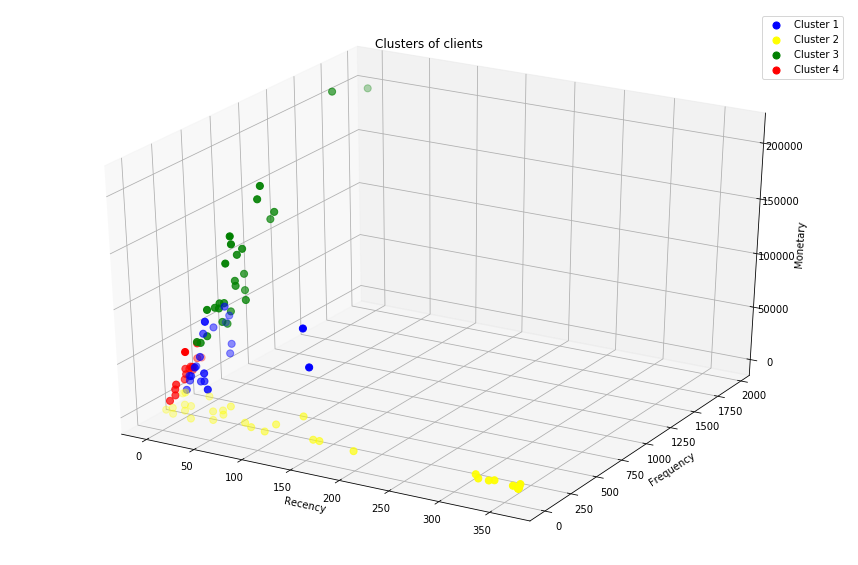

In [16]:
fig = plt.figure(figsize=(15,10))
dx = fig.add_subplot(111, projection='3d')
colors = ['blue', 'yellow', 'green', 'red']

for i in range(0,4):
    dx.scatter(RFM_final[RFM_final.Cluster == i].Recency, 
               RFM_final[RFM_final.Cluster == i].Frequency, 
               RFM_final[RFM_final.Cluster == i].Monetary, 
               c = colors[i], 
               label = 'Cluster ' + str(i+1), 
               s=50)

dx.set_title('Clusters of clients')
dx.set_xlabel('Recency')
dx.set_ylabel('Frequency')
dx.set_zlabel('Monetary')
dx.legend()

**Por como se configura este análisis, menor valor de recency implica clientes más actuales. Los mejores clientes en F v/s R se encuentran en la esquina superior izquierda.**

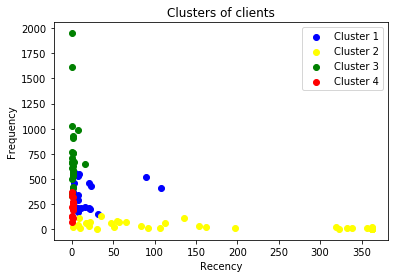

In [17]:
c1 = RFM_final[RFM_final.Cluster == 0]
c2 = RFM_final[RFM_final.Cluster == 1]
c3 = RFM_final[RFM_final.Cluster == 2]
c4 = RFM_final[RFM_final.Cluster == 3]

plt.scatter(c1.Recency, c1.Frequency, c = 'blue', label = 'Cluster 1')
plt.scatter(c2.Recency, c2.Frequency, c = 'yellow', label = 'Cluster 2')
plt.scatter(c3.Recency, c3.Frequency, c = 'green', label = 'Cluster 3')
plt.scatter(c4.Recency, c4.Frequency, c = 'red', label = 'Cluster 4')

plt.title('Clusters of clients')
plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.legend()

**Al observar F v/s M, los mejores clientes se encuentran en la esquina superior derecha.**

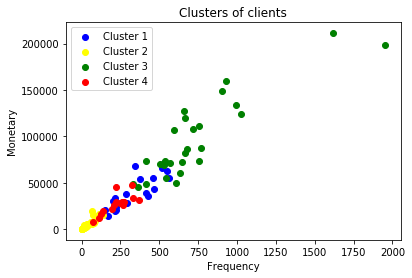

In [18]:
plt.scatter(c1.Frequency, c1.Monetary, c = 'blue', label = 'Cluster 1')
plt.scatter(c2.Frequency, c2.Monetary, c = 'yellow', label = 'Cluster 2')
plt.scatter(c3.Frequency, c3.Monetary, c = 'green', label = 'Cluster 3')
plt.scatter(c4.Frequency, c4.Monetary, c = 'red', label = 'Cluster 4')

plt.title('Clusters of clients')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.legend()

**En M v/s R, los mejores clientes se encuentran en la esquina superior izquierda.**

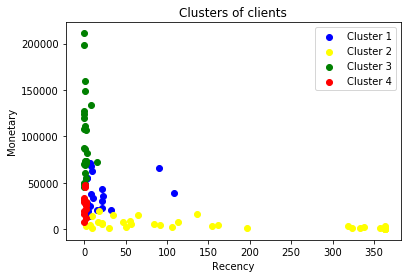

In [19]:
plt.scatter(c1.Recency, c1.Monetary, c = 'blue', label = 'Cluster 1')
plt.scatter(c2.Recency, c2.Monetary, c = 'yellow', label = 'Cluster 2')
plt.scatter(c3.Recency, c3.Monetary, c = 'green', label = 'Cluster 3')
plt.scatter(c4.Recency, c4.Monetary, c = 'red', label = 'Cluster 4')

plt.title('Clusters of clients')
plt.xlabel('Recency')
plt.ylabel('Monetary')
plt.legend()

# Mejores clientes y productos más relevantes

** Mejores clientes **

En esta sección del código es necesario seleccionar manualmente el mejor cluster, que resulta explícito en la visualización. Para una muestra de 100 clientes, el mejor cluster resulta en color verde (Cluster 3).

In [20]:
mejores_clientes = c3['Cliente'].tolist()
print(mejores_clientes)

[2, 8, 9, 11, 18, 19, 22, 23, 26, 30, 32, 37, 42, 44, 53, 54, 55, 61, 65, 72, 73, 78, 79, 80, 86, 88, 94]


** Productos más relevantes **

A partir de la lista de mejores clientes se recuperan sus transacciones de la base de datos original. Luego, se identifican los productos comprados por dichos clientes y los márgenes que generan. Finalmente, se suman los margenes generados por producto (sobre el total de transacciones realizadas por el grupo de mejores clientes), se les aplica un orden ascendente y se recuperan los 15 últimos.

Dicho porcedimiento supone que los productos más relevantes son aquellos que, en suma para la totalidad de transacciones de los mejores clientes, implican un mayor margen para la empresa.

In [21]:
# Se recuperan los datos de los mejores clientes
mejores = data[data['Cliente'].isin(mejores_clientes)]

# Se vuelve a calcular el margen de las transacciones
datMargin = pd.DataFrame({'Margen' : mejores['Venta'] - mejores['Costo']})
mejores = mejores.join(datMargin)

# Se ordenan
mejores.head()

,Fecha,Cliente,Boleta,Producto,Cantidad,Venta,Costo,Margen
7,2017-01-02,2,2,8,1,1450,1412,38
8,2017-01-02,2,2,9,1,2990,2602,388
26,2017-01-02,8,8,27,3,1680,1429,251
27,2017-01-02,8,8,28,2,1980,1757,223
28,2017-01-02,8,8,29,2,1920,1861,59


In [22]:
df = pd.DataFrame(columns = ['Producto','Margen acumulado'])

for i in mejores.Producto.unique(): # Iterando sobre los distintos productos que han comprado los mejores clientes
    
    # Se determina la suma de los margenes del producto sobre las distintas transacciones
    margen = mejores['Margen'].where( mejores['Producto'] == i ).sum() 
    
    new_row = [i, margen] # nueva fila: [id del producto, margen acumulado]
    
    # Se agrega la fila al nuevo dataframe
    df2 = pd.DataFrame([new_row], columns=['Producto','Margen acumulado'])
    df = df.append(df2)
    
# Se ordenan ascendentemente los productos de aceurdo a su margen
df = df.sort_values('Margen acumulado', ascending=True)

# Se seleccionan los 15 con mayor margen
df = df.tail(15)

** Finalmente se extrae e imprime la lista de los productos más relevantes **

In [23]:
mas_relevantes = df.Producto.values
print(mas_relevantes)

[855 221 3141 449 586 1183 3498 368 1631 520 394 3364 1012 134 1008]
